# Time series forecasting

Electricity consumption forecasting on [UCI's Electricity](https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014) dataset


In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from icecream import install
install()
import traceback
import torch
import random

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

LOCALS = ['NVD4K9M6K4', 'x1']
import socket
hostname = socket.gethostname()
IS_LOCAL = hostname in LOCALS # apply difference strategy when running local for testing purpose and running on  server for performing real training

def view_df(data: pd.DataFrame):
    pd.set_option('display.max_columns', None)
    display(data)
    pd.reset_option("max_columns")

if IS_LOCAL:
    %load_ext autoreload
    %autoreload 2

## Parameters

In [2]:
model_name = "lstm_sensor" # eran, graphic, lstm, lstm_sensor
batch_size = 32
horizontal_length = 24 # number of future time steps that need to forecast
num_sensors = -1 # -1: all available sensors, otherwise using specified number of sensors
node_dim = 4 #  for eran model only
exp_name = 'runs' # experiment name

## Download data

In [3]:
! [ ! -f LD2011_2014.txt ] && wget https://archive.ics.uci.edu/static/public/321/electricityloaddiagrams20112014.zip && unzip electricityloaddiagrams20112014.zip && rm electricityloaddiagrams20112014.zip

## Load and preprocess data
- Read csv files into pandas:DataFrame
- Perform feature engineering:
    - Encode time features as cyclic features using sine and cosine transformation, refs: https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/
- Train/Validation/test splits


In [4]:
from united.utils import convert_dataframe_from_column_sensors_to_row_sensors

df = pd.read_csv("LD2011_2014.txt", delimiter=";", header=0, decimal=",", index_col=0)
df.index = pd.to_datetime(df.index)
sensors = df.columns.to_list()

df.sort_index(inplace=True)
df = df.resample("1h").mean().replace(0.0, np.nan)


tmin = df.index.min()
time_from_start = df.index - tmin
# df['timestamp'] = df.index
df["time_idx"] = pd.to_numeric(time_from_start.seconds / 60 / 60 + time_from_start.days * 24, downcast="integer")
df["hour"] = df.index.hour
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["group_id"] = "x"

CYCLIC_COLS = [
    "hour",
    # 'minute',
    "day",
    "day_of_week",
    # 'month'
]

new_cyclic_cols = [c for col in CYCLIC_COLS for c in [f"{col}_sin", f"{col}_cos"]]
for col in CYCLIC_COLS:
    df[f"{col}_sin"] = np.sin((2 * np.pi * df[col].astype(float)) / max(df[col].astype(float)))
    df[f"{col}_cos"] = np.cos((2 * np.pi * df[col].astype(float)) / max(df[col].astype(float)))


testing_cutoff_time = pd.to_datetime("2014/08/31", format="%Y/%m/%d")
test_df = df[df.index > testing_cutoff_time]
df = df[df.index <= testing_cutoff_time]


max_encoder_length = 7 * 24
max_prediction_length = horizontal_length

training_cutoff = df["time_idx"].max() - 5 * (max_prediction_length + max_encoder_length)

train_df = df[lambda x: x.time_idx <= training_cutoff]
val_df = df[lambda x: x.time_idx > training_cutoff]

common_cols = new_cyclic_cols

print(common_cols)
to_remove_sensors = ['MT_223', 'MT_178']
# to_remove_sensors = []
sensors = [s for s in sensors if s not in to_remove_sensors]

if IS_LOCAL:
    num_sensors = 5
num_sensors = min(num_sensors, len(sensors)) if num_sensors > 0 else len(sensors)
sensors = sensors[:num_sensors]
print(f"Num sensors: {len(sensors)}")


def set_categorical_type(df):
    out = df
    time_varying_known_categoricals = ["hour", "day", "day_of_week", "month"]
    for col in time_varying_known_categoricals:
        out[col] = out[col].astype(str).astype("category")
    return out


train_df = set_categorical_type(train_df)
val_df = set_categorical_type(val_df)
test_df = set_categorical_type(test_df)


train_df_lstm = convert_dataframe_from_column_sensors_to_row_sensors(train_df, sensors, common_cols + ["time_idx"])
val_df_lstm = convert_dataframe_from_column_sensors_to_row_sensors(val_df, sensors, common_cols + ["time_idx"])
test_df_lstm = convert_dataframe_from_column_sensors_to_row_sensors(test_df, sensors, common_cols + ["time_idx"])

print(sensors, common_cols)
print(train_df.shape, val_df.shape, test_df.shape)
print(train_df_lstm.shape, val_df_lstm.shape, test_df_lstm.shape)
if IS_LOCAL:
    view_df(train_df)
    view_df(train_df_lstm)

['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos']
Num sensors: 5
['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005'] ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos']
(31153, 382) (960, 382) (2952, 382)
(155765, 9) (4800, 9) (14760, 9)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,time_idx,hour,day,day_of_week,month,group_id,hour_sin,hour_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.580542,NaN,NaN,NaN,NaN,NaN,NaN,263.888889,43.544524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.203369,NaN,38.787879,20.363985,NaN,1951.646091,170.731707,1913.978495,NaN,NaN,831.135531,NaN,56.023326,22.983670,NaN,146.988922,80.792860,NaN,72.002048,72.406798,41.150912,NaN,NaN,NaN,93.291732,NaN,37.599469,43.740138,NaN,NaN,NaN,13.174248,21.191007,204.258675,298.533724,906.474820,259.756401,262.697979,1854.519774,221.658206,12555.555556,80.645161,131.823085,276.949541,415.932452,165.087387,234.553991,308.243728,454.726368,278.248588,113.974800,343.310658,4173.669468,263.020833,466.838932,85.833333,233.333333,607.375271,196.537678,201.655983,1290.143965,111.307420,664.776307,197.849462,1282.700422,83.984036,409.333333,520.00000

,value,sensor,hour_sin,hour_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,time_idx
2011-01-01 00:00:00,NaN,MT_001,0.000000e+00,1.000000,0.201299,0.979530,-0.866025,0.5,0
2011-01-01 01:00:00,NaN,MT_001,2.697968e-01,0.962917,0.201299,0.979530,-0.866025,0.5,1
2011-01-01 02:00:00,NaN,MT_001,5.195840e-01,0.854419,0.201299,0.979530,-0.866025,0.5,2
2011-01-01 03:00:00,NaN,MT_001,7.308360e-01,0.682553,0.201299,0.979530,-0.866025,0.5,3
2011-01-01 04:00:00,NaN,MT_001,8.878852e-01,0.460065,0.201299,0.979530,-0.866025,0.5,4
...,...,...,...,...,...,...,...,...,...
2014-07-21 20:00:00,55.182927,MT_005,-7.308360e-01,0.682553,-0.897805,-0.440394,0.000000,1.0,31148
2014-07-21 21:00:00,53.658537,MT_005,-5.195840e-01,0.854419,-0.897805,-0.440394,0.000000,1.0,31149
2014-07-21 22:00:00,69.512195,MT_005,-2.697968e-01,0.962917,-0.897805,-0.440394,0.000000,1.0,31150
2014-07-21 23:00:00,65.853659,MT_005,-2.449294e-16,1.000000,-0.897805,-0.440394,0.000000,1.0,31151


## Initialize datasets

In [8]:
from united.data.timeseries import SensorTimeSeriesDataset, TimeSeriesDataset
from copy import deepcopy

if model_name in ["graphic", "eran"]:
    targets = sensors
    encoder_variables = common_cols + targets
    decoder_variables = common_cols
    train_dataset = SensorTimeSeriesDataset(
        data=train_df,
        group_ids='group_id',
        sensors=sensors + common_cols,
        time_idx='time_idx',
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_decoder_length=max_prediction_length,
        max_decoder_length=max_prediction_length,
        encoder_variables=encoder_variables,
        decoder_variables=decoder_variables,
        targets=targets,
        training=True,
        imputers={
            sensor: 'tryhard' for sensor in sensors
        },
        # return_missing_mask=True
    )

    val_dataset = SensorTimeSeriesDataset.from_dataset(train_dataset, val_df, training=False)
    test_dataset = SensorTimeSeriesDataset.from_dataset(train_dataset, test_df, training=False)
    if IS_LOCAL:
        batch_size = 8
    num_workers = 1
elif model_name in ["lstm_sensor"]:
    targets = sensors
    encoder_variables = common_cols + targets
    decoder_variables = common_cols
    train_dataset = TimeSeriesDataset(
        data=train_df,
        group_ids=['group_id'],
        time_idx='time_idx',
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_decoder_length=max_prediction_length,
        max_decoder_length=max_prediction_length,
        encoder_variables=encoder_variables,
        decoder_variables=decoder_variables,
        targets=targets,
        training=True,
        imputers={
            sensor: 'tryhard' for sensor in sensors
        },
    )

    val_dataset = TimeSeriesDataset.from_dataset(train_dataset, val_df, training=False)
    test_dataset = TimeSeriesDataset.from_dataset(train_dataset, test_df, training=False)
    if IS_LOCAL:
        batch_size = 8
    num_workers = 1
elif model_name in ["lstm"]:
    targets = ['value']
    cols = new_cyclic_cols + ['sensor']
    encoder_variables = cols + targets
    decoder_variables = cols
    train_dataset = TimeSeriesDataset(
        data=train_df_lstm,
        group_ids=['sensor'],
        time_idx='time_idx',
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_decoder_length=max_prediction_length,
        max_decoder_length=max_prediction_length,
        encoder_variables=encoder_variables,
        decoder_variables=decoder_variables,
        targets=targets,
        training=True,
        imputers={
            'value': 'tryhard',
            # 'hour': 'auto',
            # 'month': 'auto',
            # 'day': 'auto',
            # 'day_of_week': 'auto'
        },
    )

    val_dataset = TimeSeriesDataset.from_dataset(train_dataset, val_df_lstm, training=False)
    test_dataset = TimeSeriesDataset.from_dataset(train_dataset, test_df_lstm, training=False)
    if IS_LOCAL:
        num_workers = 0
    else:
        num_workers = 8
else:
    raise ValueError(f"Unknown model_name: {model_name}")
    
train_loader    = train_dataset.to_dataloader(batch_size=batch_size, num_workers=num_workers)
val_loader      = val_dataset.to_dataloader(batch_size=batch_size)
test_loader     = test_dataset.to_dataloader(batch_size=batch_size)


it_ = iter(train_loader)

ic(len(train_dataset), len(val_dataset), len(test_dataset))
ic(len(train_loader), len(val_loader), len(test_loader))

Indexing - step 1/2: 100%|██████████| 1/1 [00:00<00:00, 34.81it/s]


Finished Indexing in 33.34(s)
Preprocessing ...
Done


Indexing - step 1/2: 100%|██████████| 1/1 [00:00<00:00, 537.25it/s]


Finished Indexing in 0.90(s)
Preprocessing ...
Done


Indexing - step 1/2: 100%|██████████| 1/1 [00:00<00:00, 190.19it/s]


Finished Indexing in 2.48(s)
Preprocessing ...
Done


ic| len(train_dataset): 30961
    len(val_dataset): 768
    len(test_dataset): 2760
ic| len(train_loader): 3870
    len(val_loader): 96
    len(test_loader): 345


(3870, 96, 345)

In [6]:
from united.models.forecasting import EranForecaster, GraphICForecaster, LSTMForecaster
if model_name == 'eran':
    model = EranForecaster.from_dataset(
        train_dataset,
        reduce_on_plateau_patience=2,
        node_dim=node_dim,
        # conv_channels=64,
        # residual_channels=64,
        # skip_channels=128,
        # end_channels=128,
        # layers=3,
        # learning_rate=1e-4,
    )
elif model_name == "graphic":
    model = GraphICForecaster.from_dataset(
        train_dataset,
        reduce_on_plateau_patience=2,
        # feature_hidden_size=64,
        # event_hidden_size=16,
        # num_event_states=5,
    )
elif model_name in ["lstm", "lstm_sensor"]:
    model = LSTMForecaster.from_dataset(train_dataset, hidden_size=256)
else:
    raise ValueError(f"Unknown model name: {model_name}")
model.__class__.__name__

'LSTMForecaster'

## Inspect dataloader output

In [ ]:
if IS_LOCAL:
    x, y = next(it_)
    for name, val in x.items():
        print(name, val.shape)
    for name, val in y.items():
        print(name, val.shape)
    y_pred = model(x)
    y = model.construct_output(y)
    y = model.tensor_to_predictions(y)
    lengths = model.get_sequence_lengths(x)
    loss = model.compute_loss(y_pred, y, lengths)
    for name, val in y_pred.items():
        print(name, val.shape)
    print(f"Loss: {loss}")

## Training

In [ ]:
from lightning import Trainer
import lightning.pytorch as pl 
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
pl.seed_everything(42)
max_epochs = 50
early_stoping_callback = EarlyStopping(
    monitor='val/loss', 
    min_delta=1e-5, 
    patience=max_epochs//5, 
    verbose=False, 
    mode='min'
)
model_checkpoint_callback = ModelCheckpoint(
    monitor='val/loss', 
    mode='min', 
    save_last=True, 
    # save_top_k=1
)
lr_logger = LearningRateMonitor()
log_dir = f'{exp_name}/{model_name}/{"dev" if IS_LOCAL else "prod"}'
tb_logger = TensorBoardLogger(log_dir)

trainer = Trainer(
    max_epochs=max_epochs,
    # min_epochs=5,
    enable_model_summary=True,
    callbacks=[
        lr_logger, 
        early_stoping_callback, 
        model_checkpoint_callback
    ],
    logger=tb_logger,
    gradient_clip_val=5.,
    # max_steps=300,
    # fast_dev_run=True
    # log_every_n_steps=10
)
trainer.fit(
    model=model, 
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)
trainer.test(
    model,
    ckpt_path='best',
    dataloaders=test_loader,
)

In [ ]:
if not IS_LOCAL:
    sys.exit()

## Inference with trained models

In [5]:
from united.models.forecasting import GraphICForecaster, EranForecaster, LSTMForecaster
from united.data.timeseries import SensorTimeSeriesDataset, TimeSeriesDataset
# model_name = 'lstm_sensor'
if model_name == 'eran':
    model_path = 'runs/eran/prod/lightning_logs/version_32/checkpoints/epoch=2-step=11610.ckpt'
    model = EranForecaster.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
elif model_name == "graphic":
    model_path = 'runs/graphic/prod/lightning_logs/version_7/checkpoints/epoch=6-step=6769.ckpt'
    model = GraphICForecaster.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
elif model_name == "lstm":
    model_path = 'runs/graphic/prod/lightning_logs/version_7/checkpoints/epoch=6-step=6769.ckpt'
    model = LSTMForecaster.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
elif model_name == "lstm_sensor":
    model_path = 'runs_bench/lstm_sensor/prod/lightning_logs/version_1/checkpoints/epoch=13-step=3374.ckpt'
    model = LSTMForecaster.load_from_checkpoint(
        model_path, 
        map_location=torch.device('cpu'),
    )
    pass

model.eval()
print(model.dataset_params)


if model_name in ['eran', 'graphic']:
    print(model.dataset_params['sensors'])
    test_dataset = SensorTimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)
if model_name in ['lstm_sensor']:
    test_dataset = TimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)
elif model_name in ['lstm']:
    test_dataset = TimeSeriesDataset.from_parameters(model.dataset_params, test_df_lstm, training=False)
else:
    raise ValueError(f"Unknown model_name {model_name}")

batch_size = 4
num_workers = 1
    
test_loader     = test_dataset.to_dataloader(batch_size=batch_size, shuffle=True)

it_ = iter(test_loader)

ic(len(test_dataset))
ic(len(test_loader))

{'group_ids': ['group_id'], 'time_idx': 'time_idx', 'min_encoder_length': 168, 'max_encoder_length': 168, 'min_decoder_length': 24, 'max_decoder_length': 24, 'encoder_variables': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007', 'MT_008', 'MT_009', 'MT_010', 'MT_011', 'MT_012', 'MT_013', 'MT_014', 'MT_015', 'MT_016', 'MT_017', 'MT_018', 'MT_019', 'MT_020', 'MT_021', 'MT_022', 'MT_023', 'MT_024', 'MT_025', 'MT_026', 'MT_027', 'MT_028', 'MT_029', 'MT_030', 'MT_031', 'MT_032', 'MT_033', 'MT_034', 'MT_035', 'MT_036', 'MT_037', 'MT_038', 'MT_039', 'MT_040', 'MT_041', 'MT_042', 'MT_043', 'MT_044', 'MT_045', 'MT_046', 'MT_047', 'MT_048', 'MT_049', 'MT_050', 'MT_051', 'MT_052', 'MT_053', 'MT_054', 'MT_055', 'MT_056', 'MT_057', 'MT_058', 'MT_059', 'MT_060', 'MT_061', 'MT_062', 'MT_063', 'MT_064', 'MT_065', 'MT_066', 'MT_067', 'MT_068', 'MT_069', 'MT_070', 'MT_071', 'MT_072', 'MT_073', 'MT_07

Indexing - step 1/2: 100%|██████████| 1/1 [00:00<00:00, 226.36it/s]


Finished Indexing in 1.67(s)
Preprocessing ...


ic

Done


| len(test_dataset): 2760
ic| len(test_loader): 690


690

## Visualize the predictions

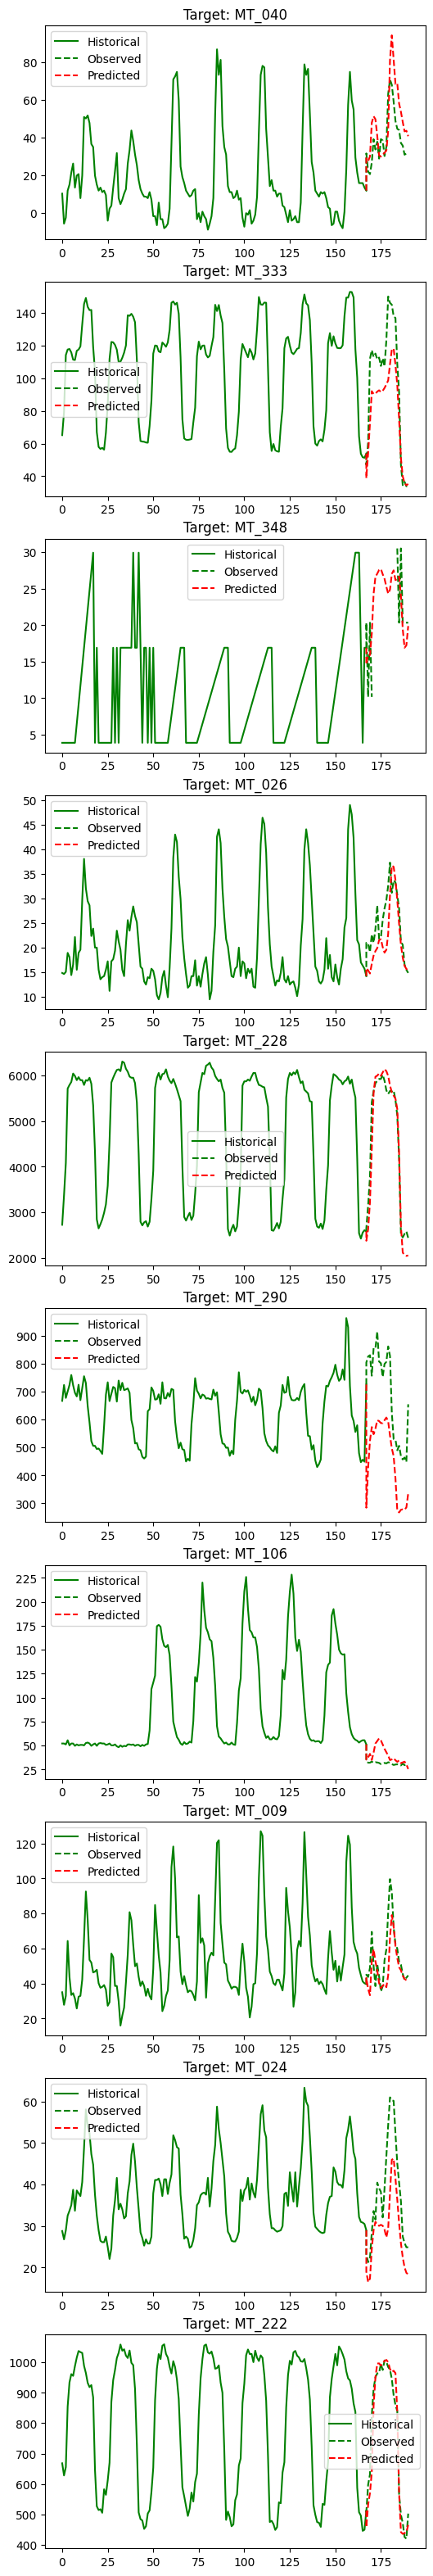

In [7]:
x, y = next(it_)
predictions = model.predict(x)
true_predictions = model.tensor_to_predictions(y['decoder'])
model.plot_prediction_multiple_targets(
    x,
    predictions,
    true_predictions,
    # targets=['MT_001']
    max_num_targets=10,
    shuffle=True
)

## Evaluate on test set with pretrained model

In [ ]:
from lightning import Trainer

trainer = Trainer()
trainer.test(
    model,
    dataloaders=test_loader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ALL/test/mae        │    157.36529541015625     │
│       ALL/test/mse        │      110763.6953125       │
│       ALL/test/rmse       │     332.8117980957031     │
│       ALL/test/rse        │    0.12539654970169067    │
│      ALL/test/smape       │    0.2029551863670349     │
│         hp_metric         │    0.09910798817873001    │
│         test/loss         │    0.09910798817873001    │
│     value/test/loss/      │    0.09910798817873001    │
│      value/test/mae       │    157.36529541015625     │
│      value/test/mse       │      110763.6953125       │
│      value/test/rmse      │     332.8117980957031     │
│      value/test/rse       │    0.12539654970169067    │
│     value/test/smape      │    0.2029551863670349     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.09910798817873001,
  'value/test/loss/': 0.09910798817873001,
  'hp_metric': 0.09910798817873001,
  'value/test/mse': 110763.6953125,
  'value/test/rmse': 332.8117980957031,
  'value/test/smape': 0.2029551863670349,
  'value/test/rse': 0.12539654970169067,
  'value/test/mae': 157.36529541015625,
  'ALL/test/mse': 110763.6953125,
  'ALL/test/rmse': 332.8117980957031,
  'ALL/test/smape': 0.2029551863670349,
  'ALL/test/rse': 0.12539654970169067,
  'ALL/test/mae': 157.36529541015625}]

In [10]:
from united.models.forecasting import GraphICForecaster, EranForecaster, LSTMForecaster
from united.data.timeseries import SensorTimeSeriesDataset, TimeSeriesDataset

def evaluate(model_path, trainer, batch_size=4):
    if "eran" in model_path:
        model = EranForecaster.load_from_checkpoint(
            model_path,
            map_location=torch.device("cpu"),
        )
        model_name = "eran"
    elif "graphic" in model_path:
        model = GraphICForecaster.load_from_checkpoint(
            model_path,
            map_location=torch.device("cpu"),
        )
        model_name = "graphic"
    elif "lstm" in model_path:
        model = LSTMForecaster.load_from_checkpoint(
            model_path,
            map_location=torch.device("cpu"),
        )
        if "lstm_sensor" in model_path:
            model_name = "lstm_sensor"
        else:
            model_name = "lstm"

    model.eval()
    print(model_path)
    print(model.__class__.__name__, model.dataset_params)

    if model_name in ['eran', 'graphic']:
        print(model.dataset_params['sensors'])
        test_dataset = SensorTimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)
    if model_name in ['lstm_sensor']:
        test_dataset = TimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)
    else:
        test_dataset = TimeSeriesDataset.from_parameters(model.dataset_params, test_df_lstm, training=False)
    test_loader = test_dataset.to_dataloader(batch_size=batch_size, shuffle=False)

    ic(len(test_dataset))
    ic(len(test_loader))
    trainer.test(
        model,
        dataloaders=test_loader,
    )

# test_df_lstm = set_categorical_type(test_df, common_cols=common_cols+['time_idx'])


model_paths = [
    # "runs/lstm/prod/lightning_logs/version_5/checkpoints/epoch=6-step=122528.ckpt",
    # "runs/eran/prod/lightning_logs/version_32/checkpoints/epoch=2-step=11610.ckpt",
    # "runs/graphic/prod/lightning_logs/version_7/checkpoints/epoch=6-step=6769.ckpt",
    "runs_bench/lstm_sensor/prod/lightning_logs/version_1/checkpoints/epoch=13-step=3374.ckpt"
    # ""
]

from lightning import Trainer

trainer = Trainer()

for model_path in model_paths:
    evaluate(model_path, trainer, batch_size=32)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LSTMForecaster {'group_ids': ['group_id'], 'time_idx': 'time_idx', 'min_encoder_length': 168, 'max_encoder_length': 168, 'min_decoder_length': 24, 'max_decoder_length': 24, 'encoder_variables': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007', 'MT_008', 'MT_009', 'MT_010', 'MT_011', 'MT_012', 'MT_013', 'MT_014', 'MT_015', 'MT_016', 'MT_017', 'MT_018', 'MT_019', 'MT_020', 'MT_021', 'MT_022', 'MT_023', 'MT_024', 'MT_025', 'MT_026', 'MT_027', 'MT_028', 'MT_029', 'MT_030', 'MT_031', 'MT_032', 'MT_033', 'MT_034', 'MT_035', 'MT_036', 'MT_037', 'MT_038', 'MT_039', 'MT_040', 'MT_041', 'MT_042', 'MT_043', 'MT_044', 'MT_045', 'MT_046', 'MT_047', 'MT_048', 'MT_049', 'MT_050', 'MT_051', 'MT_052', 'MT_053', 'MT_054', 'MT_055', 'MT_056', 'MT_057', 'MT_058', 'MT_059', 'MT_060', 'MT_061', 'MT_062', 'MT_063', 'MT_064', 'MT_065', 'MT_066', 'MT_067', 'MT_068', 'MT_069', 'MT_070', 'MT_071', 'MT_072', '

Indexing - step 1/2: 100%|██████████| 1/1 [00:00<00:00, 202.47it/s]


Finished Indexing in 3.34(s)
Preprocessing ...


ic| len(test_dataset): 2760
ic| len(test_loader): 87


Done


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       ALL/test/mae        │     66.06157684326172     │
│       ALL/test/mse        │         258992.0          │
│       ALL/test/rmse       │     90.87748718261719     │
│       ALL/test/rse        │    2.2039122581481934     │
│      ALL/test/smape       │    0.16242435574531555    │
│     MT_001/test/loss/     │    0.36282825469970703    │
│      MT_001/test/mae      │    2.3404603004455566     │
│      MT_001/test/mse      │    12.885565757751465     │
│     MT_001/test/rmse      │     3.589647054672241     │
│      MT_001/test/rse      │    0.8960214257240295     │
│     MT_001/test/smape     │    0.8782126903533936     │
│     MT_002/test/loss/     │    0.2649959623813629     │
│      MT_002/test/mae      │     2.692735195159912     │
│      MT_002/test/mse      │    11.083086967468262     │
│     MT_002/test/rmse      │     3.329127073287964     │
│      MT_002/test/rse      │    0.49190306663513184    │
│     MT_002/test/smape     │    0.10660818964242935    │
│     MT_003/test/loss/     │    0.16871996223926544    │
│      MT_003/test/mae      │    3.2894322872161865     │
│      MT_003/test/mse      │    30.385757446289062     │
│     MT_003/test/rmse      │     5.512327671051025     │
│      MT_003/test/rse      │     631.279052734375      │
│     MT_003/test/smape     │    0.9066601395606995     │
│     MT_004/test/loss/     │    0.29707083106040955    │
│      MT_004/test/mae      │    14.169388771057129     │
│      MT_004/test/mse      │     434.3251647949219     │
│     MT_004/test/rmse      │    20.840469360351562     │
│      MT_004/test/rse      │    0.2653169631958008     │
│     MT_004/test/smape     │    0.11227922141551971    │
│     MT_005/test/loss/     │    0.5652907490730286     │
│      MT_005/test/mae      │     9.683866500854492     │
│      MT_005/test/mse      │     170.7538299560547     │
│     MT_005/test/rmse      │    13.067280769348145     │
│      MT_005/test/rse      │    0.5015933513641357     │
│     MT_005/test/smape     │     0.184815913438797     │
│     MT_006/test/loss/     │    0.3177603781223297     │
│      MT_006/test/mae      │    24.615406036376953     │
│      MT_006/test/mse      │      1250.5185546875      │
│     MT_006/test/rmse      │     35.3626708984375      │
│      MT_006/test/rse      │    0.3001173734664917     │
│     MT_006/test/smape     │    0.1251673847436905     │
│     MT_007/test/loss/     │    0.17797738313674927    │
│      MT_007/test/mae      │     2.34492564201355      │
│      MT_007/test/mse      │     8.17715835571289      │
│     MT_007/test/rmse      │    2.8595731258392334     │
│      MT_007/test/rse      │    3.4312963485717773     │
│     MT_007/test/smape     │    0.5469115376472473     │
│     MT_008/test/loss/     │    0.3868091106414795     │
│      MT_008/test/mae      │     25.62211799621582     │
│      MT_008/test/mse      │     1305.769775390625     │
│     MT_008/test/rmse      │     36.13543701171875     │
│      MT_008/test/rse      │     0.353300005197525     │
│     MT_008/test/smape     │    0.09702381491661072    │
│     MT_009/test/loss/     │    0.40279850363731384    │
│      MT_009/test/mae      │    10.009636878967285     │
│      MT_009/test/mse      │    187.78834533691406     │
│     MT_009/test/rmse      │    13.703588485717773     │
│      MT_009/test/rse      │     0.643251895904541     │
│     MT_009/test/smape     │    0.18461871147155762    │
│     MT_010/test/loss/     │    0.8454984426498413     │
│      MT_010/test/mae      │    15.820823669433594     │
│      MT_010/test/mse      │     541.1417846679688     │
│     MT_010/test/rmse      │    23.262454986572266     │
│      MT_010/test/rse      │    0.7133015394210815     │
│     MT_010/test/smape     │    0.25193914771080017    │
│     MT_011/test/loss/     │    0.2920883595943451     

## Run Benchmarking

In [ ]:
import glob
from pathlib import Path
from united.models.forecasting import EranForecaster, GraphICForecaster, LSTMForecaster
from lightning import Trainer
from united.data.timeseries import SensorTimeSeriesDataset, TimeSeriesDataset

import gc

experiment_root_path = Path('./runs_bench/eran/prod/lightning_logs/')
ignore_versions = [22, 20, 16, 18, 19, 13, 11]
failed_versions = []
model_paths = []
for exp_dir in glob.glob(f"{experiment_root_path}/version_*"):
    exp_dir = Path(exp_dir)
    version = int(exp_dir.name.split('_')[1])
    if version in ignore_versions:
        print(f"Skipping version: {version}")
        continue
    # print(exp_dir, version, version in ignore_versions)
    ckpts = glob.glob(f"{exp_dir}/checkpoints/epoch=*.ckpt")
    dates = []
    last_mtime = 0
    best_ckpt = None
    for ckpt in ckpts:
        # last_mtime = os.path.getmtime(ckpt)
        # print(os.path.getmtime(ckpt))
        if os.path.getmtime(ckpt) > last_mtime:
            last_mtime = os.path.getmtime(ckpt)
            best_ckpt = ckpt
    # print("Best ckpt: ", best_ckpt)
    if best_ckpt:
        model_paths.append(best_ckpt)
    else:
        pass
        # print(exp_dir)
print(model_paths)
print(len(model_paths))
metrics = []
for model_path in model_paths:
    model = EranForecaster.load_from_checkpoint(
        model_path,
        # map_location=torch.device("cpu"),
    )
    node_dim = model.hparams["node_dim"]
    num_sensors = len(model.dataset_params["sensors"]) - 6
    print('-'*50)
    print(model_path)
    print(node_dim, num_sensors)
    if num_sensors > 256:
        batch_size = 32
    elif num_sensors < 100:
        batch_size = 64
    else:
        batch_size = 48
    
    test_dataset = SensorTimeSeriesDataset.from_parameters(model.dataset_params, test_df, training=False)
    test_loader = test_dataset.to_dataloader(batch_size=batch_size, shuffle=False)
    trainer = Trainer()
    result = trainer.test(
        model,
        dataloaders=test_loader,
        verbose=False
    )
    for metric in result:
        metric['node_dim'] = node_dim
        metric['num_sensors'] = num_sensors
        metric['model_path'] = model_path
        metric['hparams'] = model.hparams
        metrics.append(metric)
    
    del model
    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    # break

metric_df = pd.DataFrame(metrics)
import pickle
pd.to_pickle(metric_df, f'logs/metrics_df_{metric_df.shape[0]}exps.pkl')
metric_df

In [2]:
import pandas as pd
import pickle
metric_df = pickle.load(open('logs/metrics_df_16exps.pkl', 'rb'))
import plotly.express as px

objective = 'ALL/test/mae'
# objective = 'ALL/test/mse'
# objective = 'test/loss'
# objective = 'ALL/test/rse'
df = metric_df[metric_df["test/loss"]<0.6]
# fig = px.parallel_coordinates(
fig = px.parallel_categories(
    df,
    color=objective,
    dimensions=[
        # 'max_decoder_length',
        'node_dim',
        "num_sensors"
    ],
    color_continuous_scale=px.colors.diverging.Tealrose
)
fig.show()

In [ ]:
df[df['num_sensors'] > 256]

,test/loss,MT_001/test/loss/,MT_002/test/loss/,MT_003/test/loss/,MT_004/test/loss/,MT_005/test/loss/,MT_006/test/loss/,MT_007/test/loss/,MT_008/test/loss/,MT_009/test/loss/,...,MT_369/test/mse,MT_369/test/rmse,MT_369/test/smape,MT_369/test/rse,MT_369/test/mae,MT_370/test/mse,MT_370/test/rmse,MT_370/test/smape,MT_370/test/rse,MT_370/test/mae


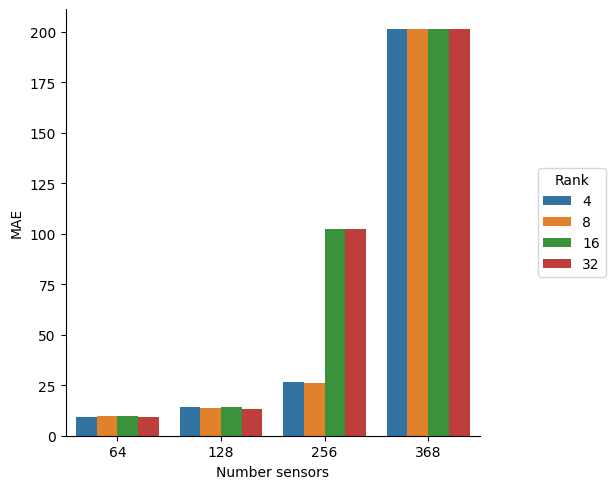

In [3]:
import seaborn
from matplotlib import pyplot as plt
df = metric_df[
    1 &
    (metric_df["test/loss"]<.6) &
    # (metric_df["node_dim"] == node_dim) &
    1
]
df = metric_df
g = seaborn.catplot(
    # x='node_dim',
    # y=objective,
    # hue='num_sensors',
    
    x='num_sensors',
    y=objective,
    hue='node_dim',
    
    legend=False,
    legend_out=True,
    errorbar=None,
    data=df,
    kind='bar',
)
plt.ylabel('MAE')

# plt.xlabel("Rank")
# legend = "Number sensors"

plt.xlabel("Number sensors")
legend = "Rank"

_ = plt.legend(title=legend, loc='center right', bbox_to_anchor=(1.32, 0.5))